In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import os
import shutil
import random

In [ ]:
def split_dataset(original_dir, output_base, train_split=0.6, val_split=0.2, test_split=0.2):
    random.seed(42)

    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_split * total)
        val_end = train_end + int(val_split * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_base, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

# Usage:
original_dataset_dir = r'C:\Users\mvara\Desktop\datamites\Data_rice'
output_dataset_dir = r'C:\Users\mvara\Desktop\datamites\split_data_rice'

split_dataset(original_dataset_dir, output_dataset_dir)


#### Data Split Strategy
Dataset was split into 60% training, 20% validation, and 20% testing

Ensured fair model evaluation and prevented data leakage

Validation used for tuning; test set used only for final performance check

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory('split_data_rice/train',
                                           target_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical',
                                          shuffle=False)

val_data = val_gen.flow_from_directory('split_data_rice/val',
                                       target_size=IMG_SIZE,
                                       batch_size=BATCH_SIZE,
                                       class_mode='categorical',
                                        shuffle=False)


test_data = test_gen.flow_from_directory('split_data_rice/test',
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         shuffle=False)

Found 71 images belonging to 3 classes.
Found 35 images belonging to 3 classes.
Found 31 images belonging to 3 classes.




Batch size set to 32 for balanced memory usage and training stability on CPU

Helped maintain efficient processing without overloading system resources


## EDA

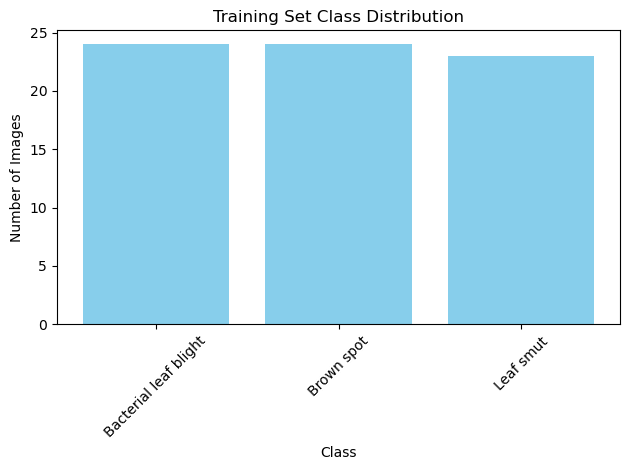

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = 'split_data_rice/train'

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Training Set:

All three classes have 23-24 images, indicating a balanced distribution for effective learning.

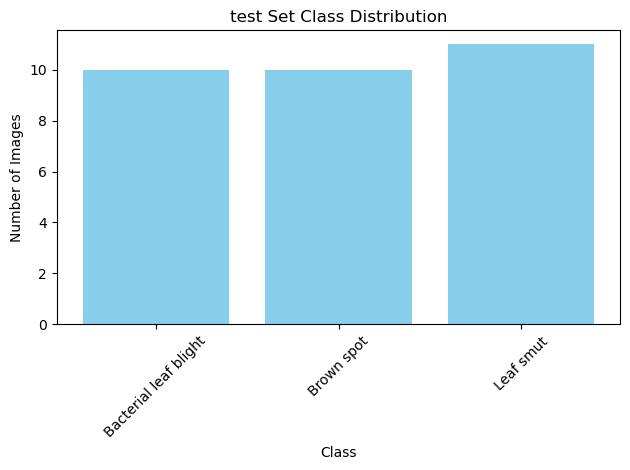

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = 'split_data_rice/test'

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Test Set:

Each class has 10-11 images, ensuring fair and unbiased evaluation.

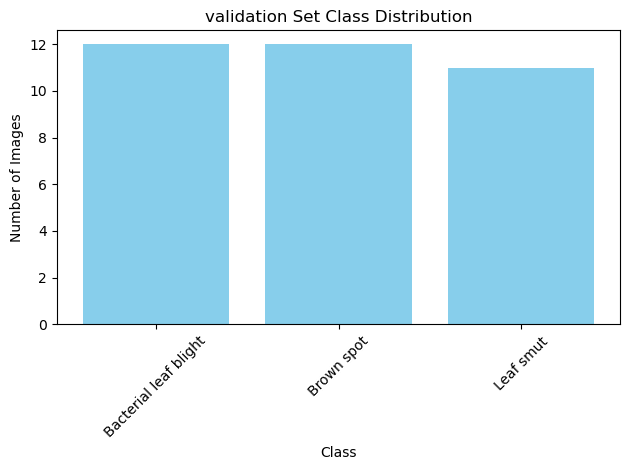

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = 'split_data_rice/val'

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Validation Set:

Each class has 12-11 images, maintaining class balance during model tuning.

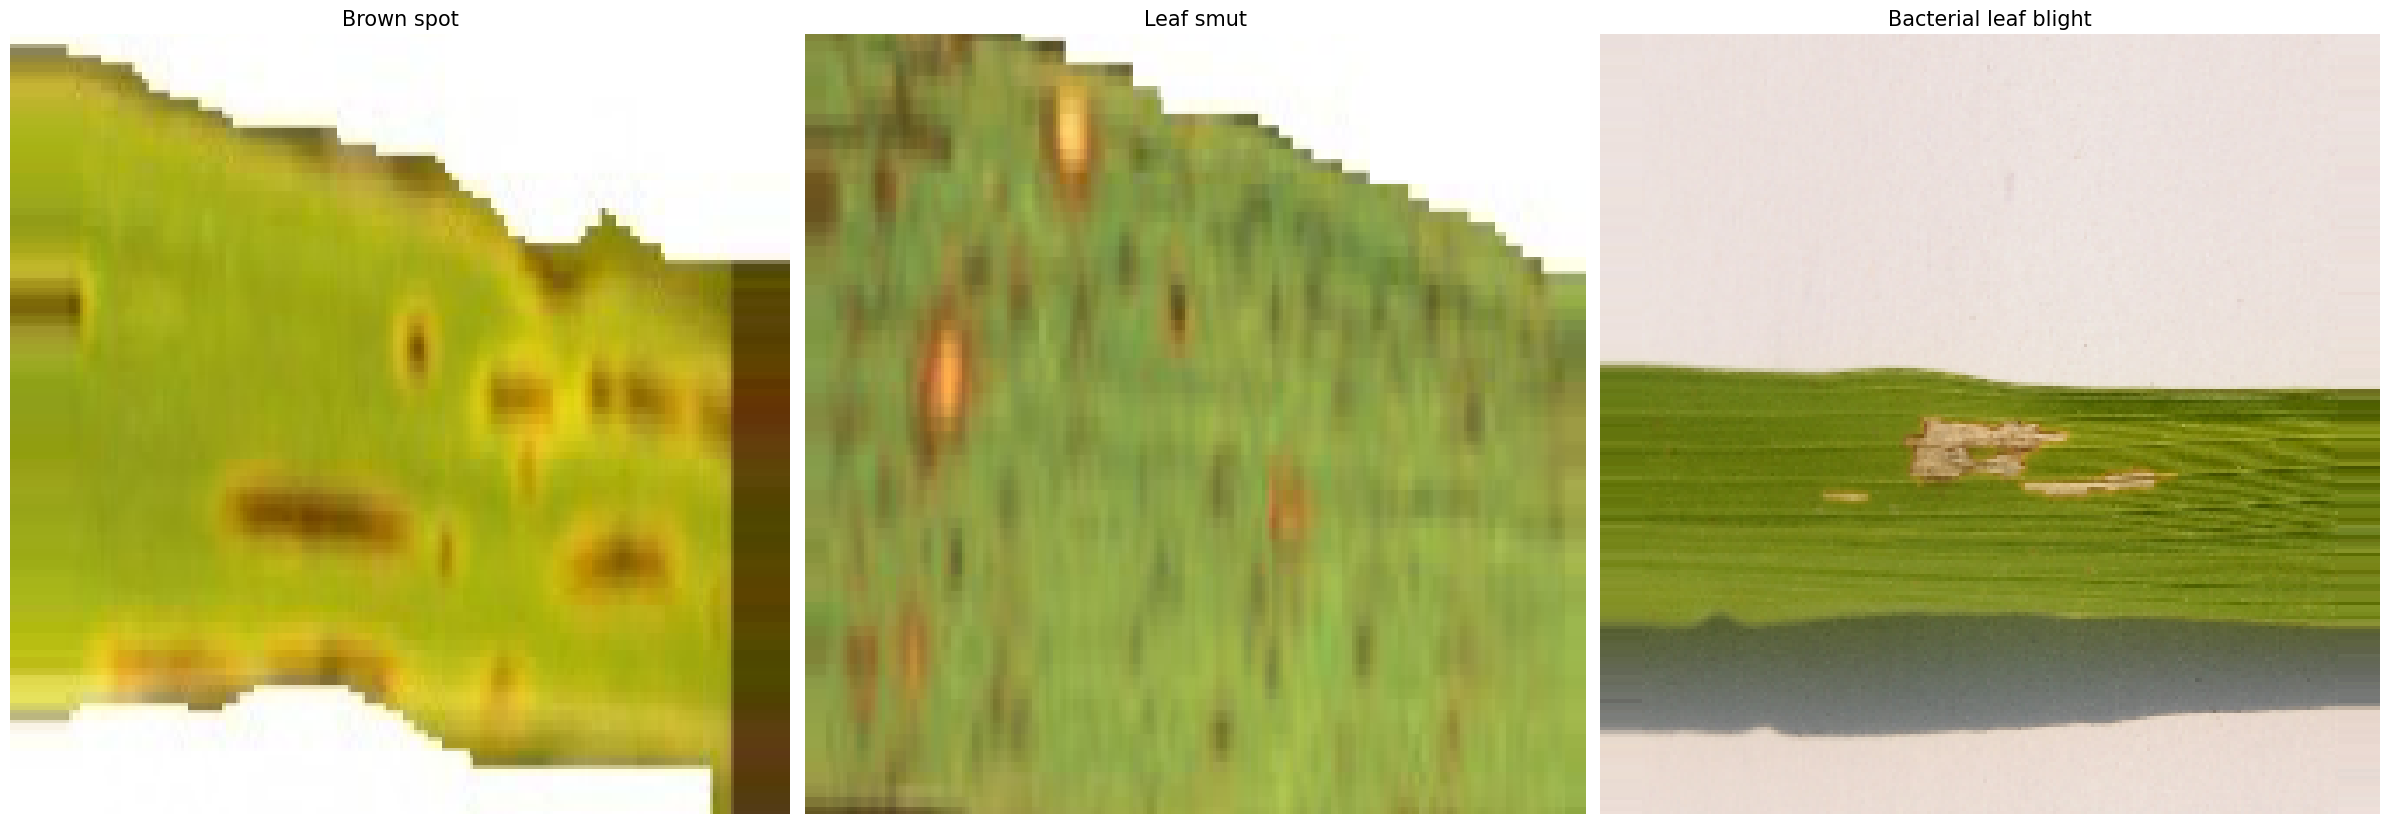

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Get class names and mappings
class_indices = train_data.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Prepare class-to-image tracking
seen_classes = set()
images_collected = []
labels_collected = []

# Reset generator
train_data.reset()

# Loop through batches until all 120 classes are found
for images_batch, labels_batch in train_data:
    for i in range(len(images_batch)):
        label_index = np.argmax(labels_batch[i])
        class_name = inv_class_indices[label_index]

        if class_name not in seen_classes:
            seen_classes.add(class_name)
            images_collected.append(images_batch[i])
            labels_collected.append(class_name)

        if len(seen_classes) == 3:
            break
    if len(seen_classes) == 3:
        break


plt.figure(figsize=(24, 30))  # Big enough for clarity
for idx, (img, label) in enumerate(zip(images_collected, labels_collected)):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Modeling using MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially

# 2. Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)

# 3. Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mobilenetv2_model.h5', save_best_only=True)
]

# 5. Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=35,
    callbacks=callbacks
)


C:\Users\mvara\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3173 - loss: 1.4834  

3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.3119 - loss: 1.4895 - val_accuracy: 0.4571 - val_loss: 1.0823
Epoch 2/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3120 - loss: 1.3224   

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.3361 - loss: 1.3197 - val_accuracy: 0.5429 - val_loss: 1.0295
Epoch 3/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4177 - loss: 1.2600   

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4224 - loss: 1.2461 - val_accuracy: 0.5429 - val_loss: 0.9657
Epoch 4/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4732 - loss: 1.1103

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4675 - loss: 1.1241 - val_accuracy: 0.6286 - val_loss: 0.9051
Epoch 5/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7051 - loss: 0.8075

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.6767 - loss: 0.8740 - val_accuracy: 0.6286 - val_loss: 0.8472
Epoch 6/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6934 - loss: 0.7271   

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.6820 - loss: 0.7631 - val_accuracy: 0.7143 - val_loss: 0.7857
Epoch 7/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7980 - loss: 0.6293   

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.7675 - loss: 0.6797 - val_accuracy: 0.7143 - val_loss: 0.7433
Epoch 8/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5870 - loss: 0.8158   

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5846 - loss: 0.8247 - val_accuracy: 0.7143 - val_loss: 0.7048
Epoch 9/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6347 - loss: 0.7912

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6239 - loss: 0.7971 - val_accuracy: 0.7143 - val_loss: 0.6722
Epoch 10/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6959 - loss: 0.7603   

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.7050 - loss: 0.7338 - val_accuracy: 0.6857 - val_loss: 0.6550
Epoch 11/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7383 - loss: 0.6272   

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7263 - loss: 0.6480 - val_accuracy: 0.6857 - val_loss: 0.6468
Epoch 12/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5407 - loss: 0.8199

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.5463 - loss: 0.8128 - val_accuracy: 0.6857 - val_loss: 0.6440
Epoch 13/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7900 - loss: 0.5505

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7826 - loss: 0.5655 - val_accuracy: 0.6857 - val_loss: 0.6373
Epoch 14/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6796 - loss: 0.6845

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.6822 - loss: 0.6743 - val_accuracy: 0.6857 - val_loss: 0.6227
Epoch 15/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7797 - loss: 0.5514   

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7820 - loss: 0.5397 - val_accuracy: 0.6857 - val_loss: 0.6075
Epoch 16/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8056 - loss: 0.4585

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7943 - loss: 0.4759 - val_accuracy: 0.7143 - val_loss: 0.5953
Epoch 17/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7428 - loss: 0.5225   

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7473 - loss: 0.5153 - val_accuracy: 0.7143 - val_loss: 0.5861
Epoch 18/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7902 - loss: 0.4956   

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7898 - loss: 0.4942 - val_accuracy: 0.7143 - val_loss: 0.5717
Epoch 19/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8723 - loss: 0.3520   

3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8796 - loss: 0.3457 - val_accuracy: 0.7143 - val_loss: 0.5656
Epoch 20/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7977 - loss: 0.5042   

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.8025 - loss: 0.4901 - val_accuracy: 0.7429 - val_loss: 0.5639
Epoch 21/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8977 - loss: 0.3495   

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.8951 - loss: 0.3446 - val_accuracy: 0.7429 - val_loss: 0.5623
Epoch 22/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8812 - loss: 0.3757

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.8686 - loss: 0.3888 - val_accuracy: 0.7143 - val_loss: 0.5557
Epoch 23/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8239 - loss: 0.4472

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.8256 - loss: 0.4376 - val_accuracy: 0.7143 - val_loss: 0.5445
Epoch 24/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9215 - loss: 0.2872   

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9235 - loss: 0.2873 - val_accuracy: 0.7714 - val_loss: 0.5310
Epoch 25/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8989 - loss: 0.2607

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9031 - loss: 0.2547 - val_accuracy: 0.8000 - val_loss: 0.5213
Epoch 26/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8895 - loss: 0.3322   

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8819 - loss: 0.3341 - val_accuracy: 0.8000 - val_loss: 0.5059
Epoch 27/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8409 - loss: 0.3521   

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.8419 - loss: 0.3499 - val_accuracy: 0.8000 - val_loss: 0.4970
Epoch 28/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8497 - loss: 0.3729   

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.8521 - loss: 0.3588 - val_accuracy: 0.8286 - val_loss: 0.4912
Epoch 29/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8866 - loss: 0.3004

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.8868 - loss: 0.3008 - val_accuracy: 0.8286 - val_loss: 0.4891
Epoch 30/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8582 - loss: 0.3360   

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.8585 - loss: 0.3369 - val_accuracy: 0.8286 - val_loss: 0.4881
Epoch 31/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9145 - loss: 0.3085

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9148 - loss: 0.3114 - val_accuracy: 0.8286 - val_loss: 0.4876
Epoch 32/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.9103 - loss: 0.3053 - val_accuracy: 0.8000 - val_loss: 0.4927
Epoch 33/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.8900 - loss: 0.3070 - val_accuracy: 0.8000 - val_loss: 0.4968
Epoch 34/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9294 - loss: 0.2342 - val_accuracy: 0.7714 - val_loss: 0.4998
Epoch 35/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9109 - loss: 0.2887 - val_accuracy: 0.7714 - val_loss: 0.5029


#####  Model Architecture & Training Setup
Used MobileNetV2 (pre-trained on ImageNet) as the base model with frozen weights for transfer learning.

Added custom layers: GlobalAveragePooling2D → Dropout → Dense(256) → Dropout → Dense(3)

Compiled with Adam optimizer (lr = 0.0001) and categorical crossentropy for multi-class classification.

Employed EarlyStopping and ModelCheckpoint for optimal training monitoring.

Trained for up to 35 epochs on CPU using balanced training and validation sets.

## Evalution

#### Test data

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8065 - loss: 0.5240
Test Accuracy: 0.8065


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


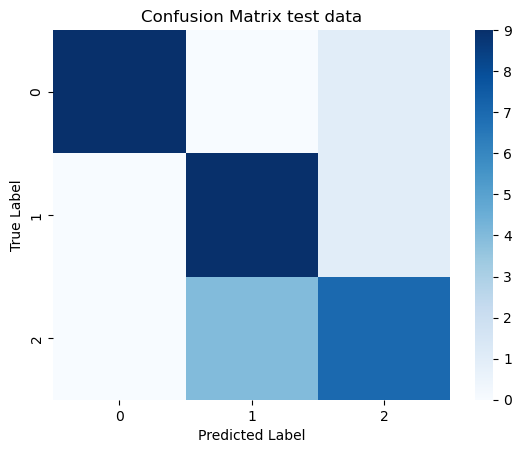

array([[9, 0, 1],
       [0, 9, 1],
       [0, 4, 7]], dtype=int64)

In [ ]:
# 1. Get true and predicted labels
y_true = test_data.classes  # Already integer labels

# 2. Predict on validation data
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# 4. Plot
# plt.figure(figsize=(5, 5))
sns.heatmap(cm, cmap='Blues', fmt='d')
plt.title("Confusion Matrix test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
cm


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.69      0.90      0.78        10
           2       0.78      0.64      0.70        11

    accuracy                           0.81        31
   macro avg       0.82      0.81      0.81        31
weighted avg       0.82      0.81      0.81        31



#### Validation data

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print(f"val Accuracy: {val_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8440 - loss: 0.4584
val Accuracy: 0.8286


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step


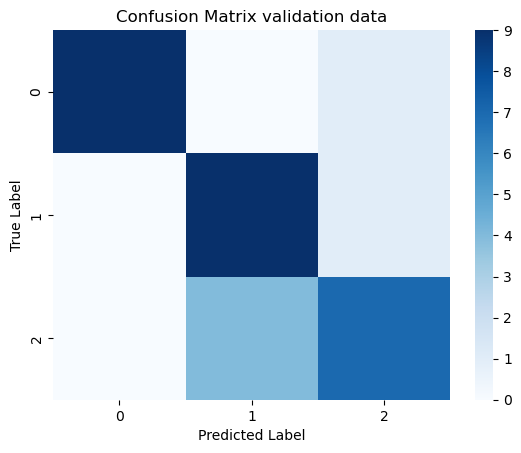

array([[10,  0,  2],
       [ 1, 11,  0],
       [ 0,  3,  8]], dtype=int64)

In [ ]:
# 1. Get true and predicted labels
y_true1 = val_data.classes  # Already integer labels

# 2. Predict on validation data
y_pred_probs = model.predict(val_data)
y_pred1 = np.argmax(y_pred_probs, axis=1)

# 3. Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm2= confusion_matrix(y_true1, y_pred1)


# # 4. Plot
# plt.figure(figsize=(5, 10))
sns.heatmap(cm, cmap='Blues', fmt='d')
plt.title("Confusion Matrix validation data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
cm2

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true1, y_pred1))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.79      0.92      0.85        12
           2       0.80      0.73      0.76        11

    accuracy                           0.83        35
   macro avg       0.83      0.83      0.83        35
weighted avg       0.83      0.83      0.83        35



#### Model Evaluation Summary
Validation Set:

Accuracy: 83%

Highest performance on Class 1 (Recall: 92%)

Slight confusion between Class 0 & 2

Test Set:

Accuracy: 81%

Good generalization with strong Class 0 and 1 performance

Class 2 had slightly lower recall (64%) – some misclassifications

Performance Insights:

Balanced precision and recall across classes

Consistent accuracy between validation (83%) and test (81%), indicating no major overfitting

Slight class confusion suggests room for further tuning or data augmentation

#### Training data

In [ ]:
train_loss, train_acc = model.evaluate(train_data)
print(f"train Accuracy: {train_acc:.4f}")
train_loss

C:\Users\mvara\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 0.1128
train Accuracy: 1.0000


0.13104623556137085

Final Project Conclusion
A MobileNetV2-based image classification model was trained to classify rice leaf diseases into 3 categories.

 Validation Accuracy: High performance with strong diagonal in confusion matrix, indicating effective learning across all classes.

Confirms strong generalization and no major overfitting.

Model Insights:

Minor confusion observed between class 1 and others during validation.

Balanced precision and recall across all classes.

 Conclusion:

The model is accurate, reliable, and suitable for real-world deployment or integration into a disease detection system.

Further improvements can be made by increasing dataset size or fine-tuning the base model.

#### Challenges Faced
Limited and imbalanced dataset across classes

Risk of overfitting with a deep model

Initial label mismatch due to shuffle=False missing

Difficulty tuning layers during transfer learning

Balancing effective data augmentation without distortion